#` DecisionTreeClassifier 사용하여 유방암 양성(2), 악성(4) 이진분류 모델로 정의`

In [ ]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 13.3 MB/s eta 0:00:00


## 기본 패키지 import

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

import pandas as pd
import numpy as np

## 데이터 준비하기


*   https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original



In [ ]:
# UCI ML Repository 제공하는 Breast Cancer 데이터셋 가져오기
uci_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
breast-cancer-wisconsin/breast-cancer-wisconsin.data'

df = pd.read_csv(uci_path, header = None) # 헤더 없음

# 칼럼명 지정
''' 1. Sample code number:            id number
2. Clump Thickness:               1 - 10
3. Uniformity of Cell Size:       1 - 10
4. Uniformity of Cell Shape:      1 - 10
5. Marginal Adhesion:             1 - 10
6. Single Epithelial Cell Size:   1 - 10
7. Bare Nuclei:                   1 - 10
8. Bland Chromatin:               1 - 10
9. Normal Nucleoli:               1 - 10
10. Mitoses:                       1 - 10
11. Class:                        (2 for benign, 4 for malignant) '''

# 칼럼 이름을 지정 -> 공백처리
df.columns = ['id', 'clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial',
              'bare_nuclei', 'chromatin', 'normal_nucleoli', 'mitoses', 'class']


df

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               699 non-null    int64 
 1   clump            699 non-null    int64 
 2   cell_size        699 non-null    int64 
 3   cell_shape       699 non-null    int64 
 4   adhesion         699 non-null    int64 
 5   epithlial        699 non-null    int64 
 6   bare_nuclei      699 non-null    object
 7   chromatin        699 non-null    int64 
 8   normal_nucleoli  699 non-null    int64 
 9   mitoses          699 non-null    int64 
 10  class            699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


## 데이터 전처리

In [ ]:
# df['bare_nuclei'] -> object -> '?' -> np.nan 변경 -> NaN 삭제 -> int 형변환
df['bare_nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [ ]:
# np.nan 변경
df['bare_nuclei'].replace('?', np.nan, inplace=True)
df['bare_nuclei'].isna().sum() #nan 데이터 수 세기

16

In [ ]:
# df['bare_nuclei'] NaN 데이터 삭제
df.dropna(subset=['bare_nuclei'], axis=0, inplace=True)
df['bare_nuclei'].isna().sum()

0

In [ ]:
# int형 변환
df['bare_nuclei'] = df['bare_nuclei'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               683 non-null    int64
 1   clump            683 non-null    int64
 2   cell_size        683 non-null    int64
 3   cell_shape       683 non-null    int64
 4   adhesion         683 non-null    int64
 5   epithlial        683 non-null    int64
 6   bare_nuclei      683 non-null    int64
 7   chromatin        683 non-null    int64
 8   normal_nucleoli  683 non-null    int64
 9   mitoses          683 non-null    int64
 10  class            683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


## 데이터 분석 (feature 확인)

### 예측하고자 하는 target (class 칼럼)의 비율 확인

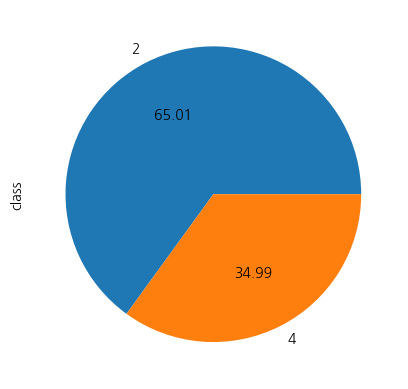

In [ ]:
# class (2 for benign, 4 for malignant) 비율 확인
df['class'].value_counts().plot.pie(autopct='%.2f');

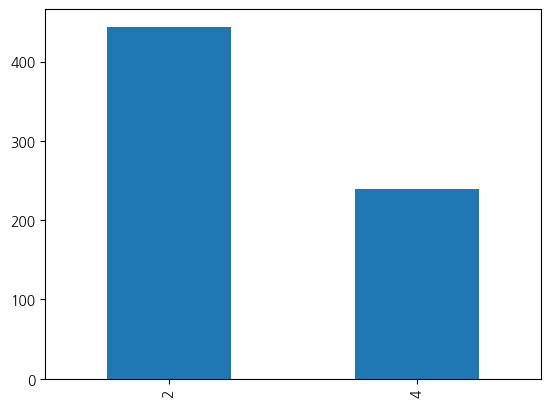

In [ ]:
df['class'].value_counts().plot.bar();

### target 과 feature 간의 연관성 확인

In [ ]:
df.head()

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


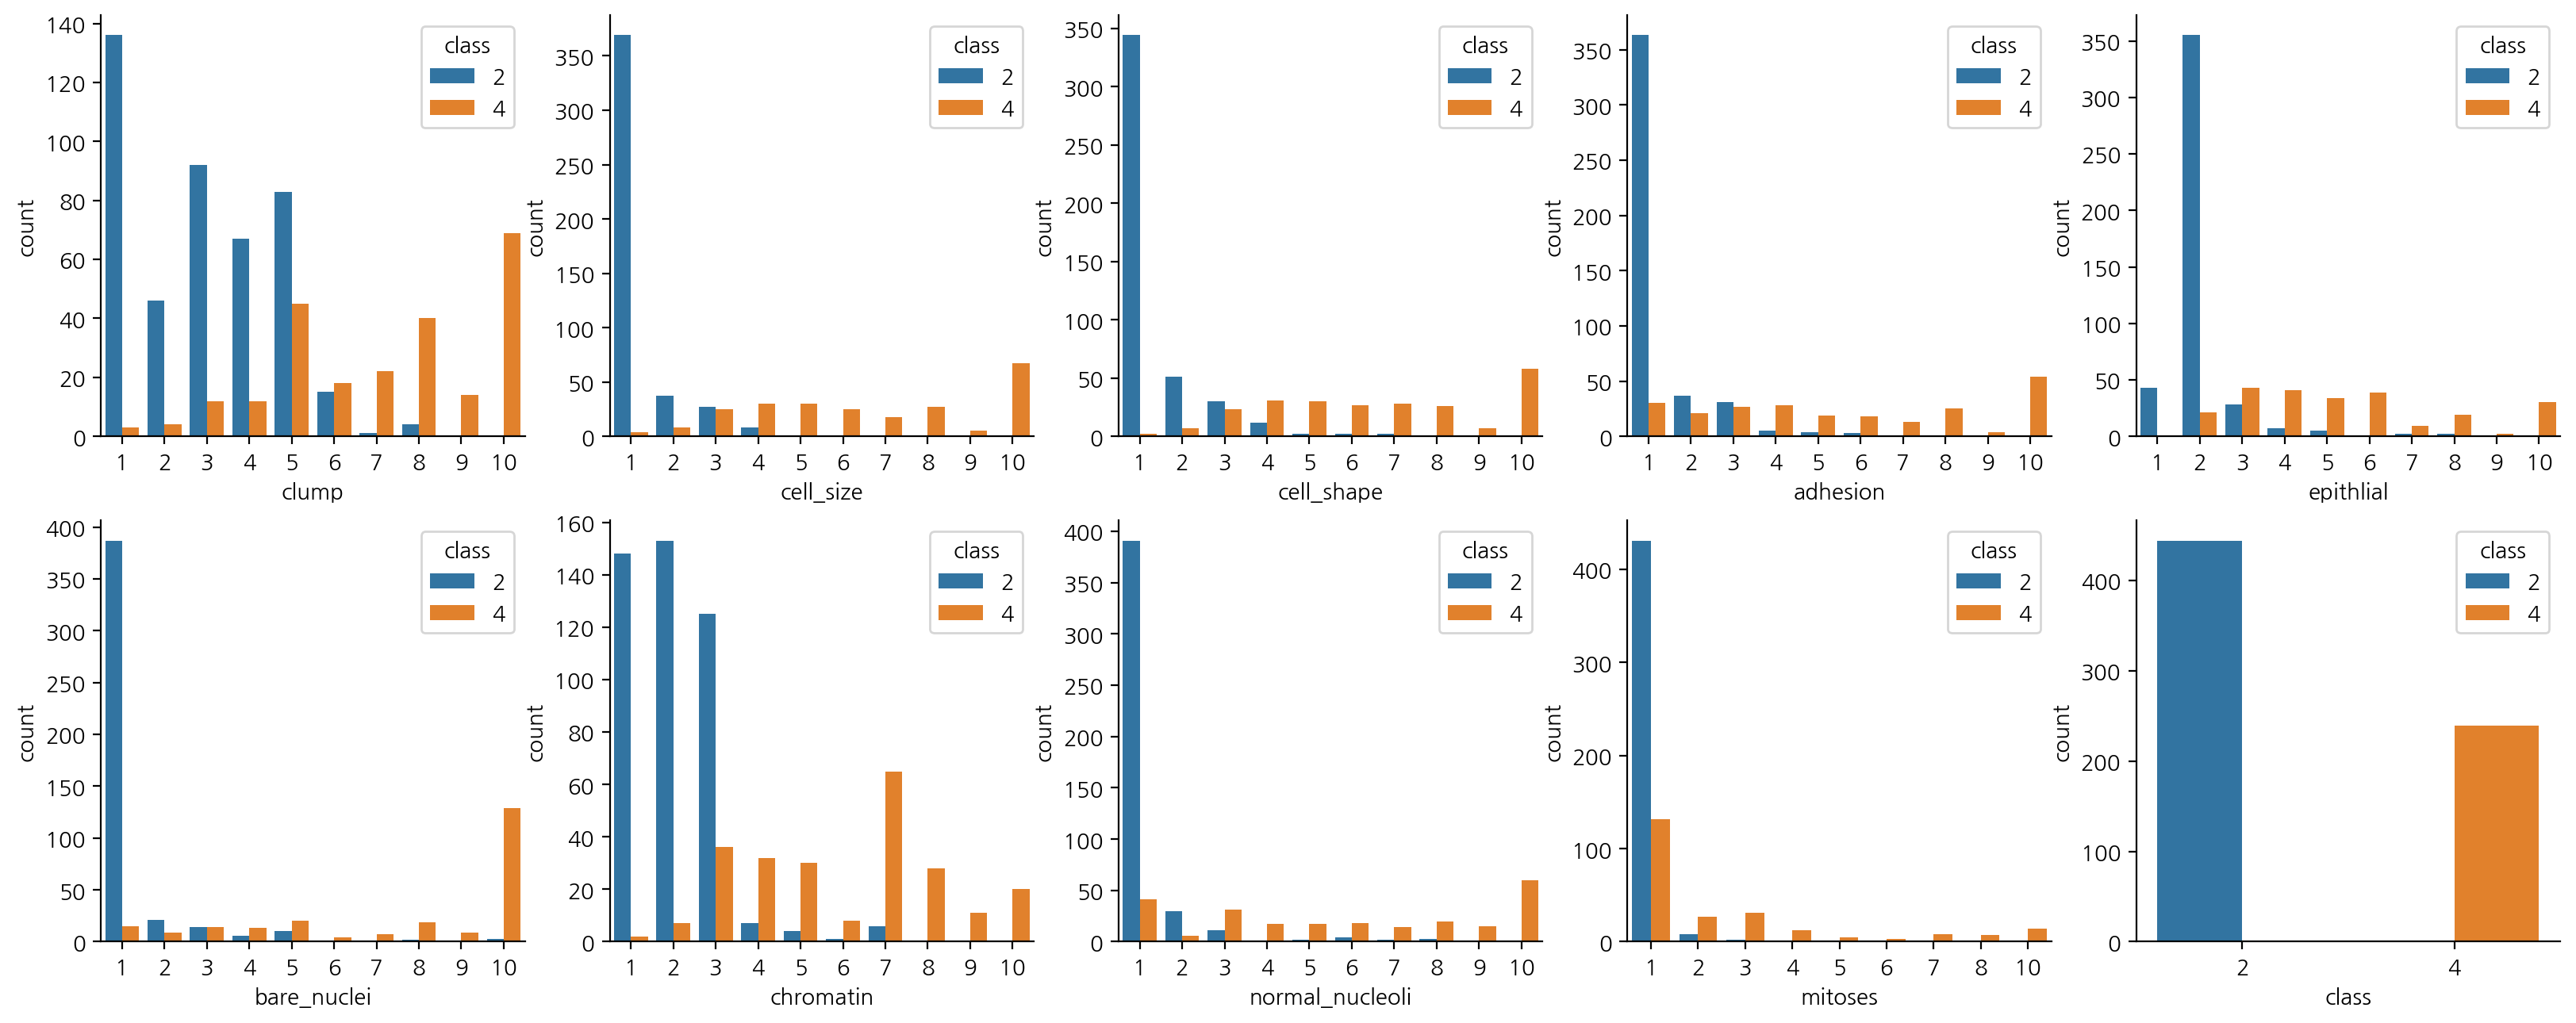

In [ ]:
# id 칼럼을 제외한 Target과 Feature의 연관성 확인
attrs = df.columns[1:]

plt.figure(figsize=(20, 20), dpi = 200)

for i, feature in enumerate(attrs) :
  plt.subplot(5, 5, i+1)
  sns.countplot(df, x = feature, hue = 'class')

sns.despine()

## 데이터 분리하기

### X, y 분리

In [ ]:
# X, y 분리 후 trainset/testset으로 분리

X = df[df.columns[1:-1]] # id, class 칼럼을 제외한 feature 데이터프레임
y = df[df.columns[-1]] # class 칼럼의 target 시리즈

X # 데이터프레임

,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1
...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1
695,2,1,1,1,2,1,1,1,1
696,5,10,10,3,7,3,8,10,2
697,4,8,6,4,3,4,10,6,1


In [ ]:
y # 시리즈 형태

0      2
1      2
2      2
3      2
4      2
      ..
694    2
695    2
696    4
697    4
698    4
Name: class, Length: 683, dtype: int64

### trainset/testset으로 분리

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

print('X_train.shape : ', X_train.shape)
print('X_test.shape : ', X_test.shape)

X_train.shape :  (478, 9)
X_test.shape :  (205, 9)


## DesicionTree 분류 모델 설정

In [ ]:
# 최적의 속성을 찾기 위해 criterion='entropy', 적정한 레벨 값을 찾기 위해 max_depth=5
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

## 모델 학습하기

In [ ]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

## 모델 예측하기

In [ ]:
y_pred = tree_model.predict(X_test)

## 모델 성능 평가하기

In [ ]:
print('훈련 데이터셋 정확도 : ', tree_model.score(X_train, y_train))
print('테스트 데이터셋 정확도 : ', tree_model.score(X_test, y_test))

훈련 데이터셋 정확도 :  0.9769874476987448
테스트 데이터셋 정확도 :  0.9463414634146341


In [ ]:
tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

              precision    recall  f1-score   support

           2       0.98      0.94      0.96       133
           4       0.90      0.96      0.93        72

    accuracy                           0.95       205
   macro avg       0.94      0.95      0.94       205
weighted avg       0.95      0.95      0.95       205



In [ ]:
print('accuracy : ', metrics.accuracy_score(y_test, y_pred))
# print('precision : ', metrics.precision_score(y_test, y_pred)) # 0과 1로 인코딩을 하지 않았기 때문에 출력 불가
# print('recall : ', metrics.recall_score(y_test, y_pred))
# print('f1 : ', metrics.f1_score(y_test, y_pred))

accuracy :  0.9463414634146341


## 결정트리 그래프 그리기

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(tree_model, out_file='tree.dot', class_names=['양성', '악성'],
                feature_names=df.columns[1:10], impurity=False, filled=True)

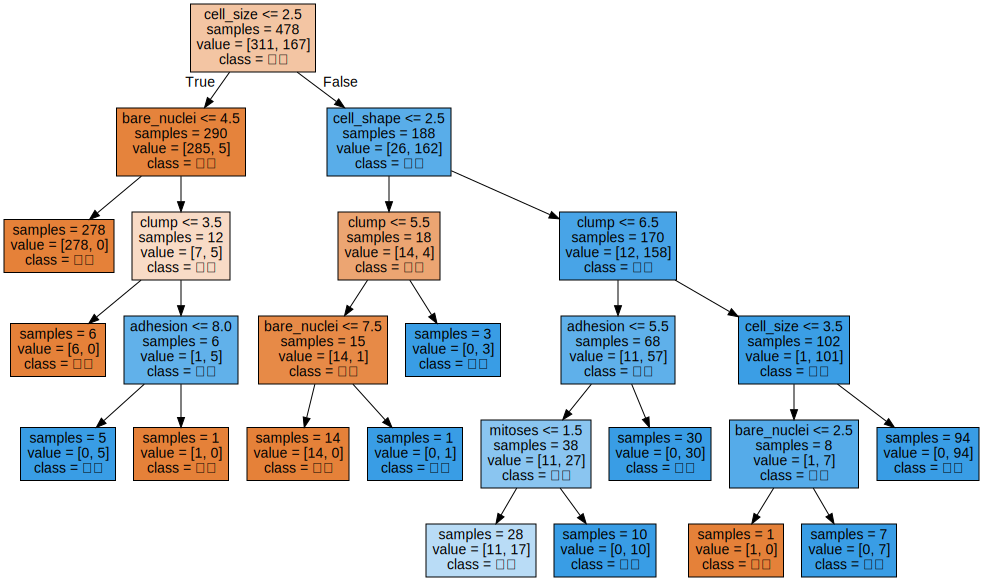

In [ ]:
import graphviz

with open('tree.dot') as f:
  dot_graph = f.read()

display(graphviz.Source(dot_graph))

## max_depth 변화에 따른 성능 평가

In [ ]:
# 1~10 까지 max_depth를 변화시켜 가장 최적의 max_depth 찾기

train_scores = {}
test_scores = {}

# tree max_depth 1 ~ 10까지 증가시켜 정확도 측정
for idx in np.arange(1,11) :
  tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=idx).fit(X_train, y_train)
  train_scores[idx] = tree_model.score(X_train, y_train)
  test_scores[idx] = tree_model.score(X_test, y_test)

# 훈련, 테스트셋의 가장 높은 정확도의 max_depth 확인
max_train_key = max(train_scores, key = train_scores.get)
max_test_key = max(test_scores, key = test_scores.get)

print('훈련 데이터셋 최적의 max_depth : ', max_train_key, '정확도 : ', train_scores[max_train_key])
print('테스트 데이터셋 최적의 max_depth : ', max_test_key, '정확도 : ', test_scores[max_test_key])

훈련 데이터셋 최적의 max_depth :  10 정확도 :  1.0
테스트 데이터셋 최적의 max_depth :  6 정확도 :  0.9512195121951219


### 성능평가 시각화

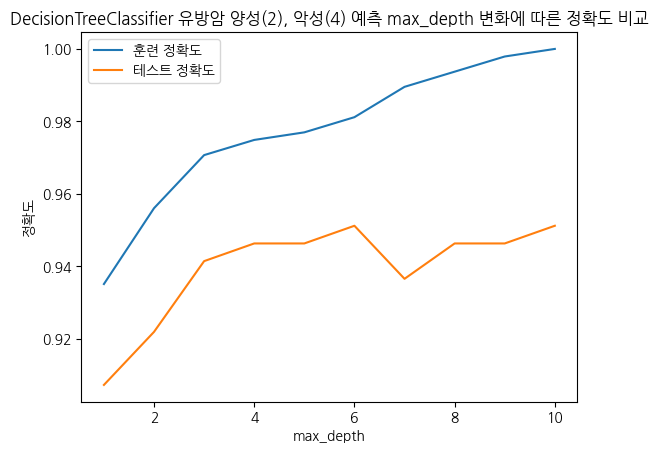

In [ ]:
plt.title('DecisionTreeClassifier 유방암 양성(2), 악성(4) 예측 max_depth 변화에 따른 정확도 비교')
plt.plot(train_scores.keys(), train_scores.values(), label = '훈련 정확도')
plt.plot(test_scores.keys(), test_scores.values(), label = '테스트 정확도')

plt.ylabel('정확도')
plt.xlabel('max_depth')
plt.legend()
plt.show()


# DecisionTreeClassifier 사용하여 유방암 양성(0), 악성(1) 이진분류 모델로 정의


*   class 칼럼의 값을 2 -> 0, 4 -> 1로 변경
*   기존 전처리 동일하게 진행(dropna)
*   X, y로 분리 후 X 값 정규화 (preprocessing.StandardScaler() 사용)
*   max_depth 1 ~ 20 까지 변환하여, 최적점 찾기
*   최적점 적용한 모델의 성능평가(precision, recall, f1)
*   모델 그래프 그리기







## 기본 패키지 import

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

import pandas as pd
import numpy as np

## 데이터 준비하기

In [ ]:
# UCI ML Repository 제공하는 Breast Cancer 데이터셋 가져오기
uci_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
breast-cancer-wisconsin/breast-cancer-wisconsin.data'

df = pd.read_csv(uci_path, header = None) # 헤더 없음

# 칼럼 이름을 지정 -> 공백처리
df.columns = ['id', 'clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial',
              'bare_nuclei', 'chromatin', 'normal_nucleoli', 'mitoses', 'class']

df

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


## 데이터 전처리

In [ ]:
# np.nan 변경
df['bare_nuclei'].replace('?', np.nan, inplace=True)
df['bare_nuclei'].isna().sum() #nan 데이터 수 세기

# df['bare_nuclei'] NaN 데이터 삭제
df.dropna(subset=['bare_nuclei'], axis=0, inplace=True)
df['bare_nuclei'].isna().sum()

# int형 변환
df['bare_nuclei'] = df['bare_nuclei'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               683 non-null    int64
 1   clump            683 non-null    int64
 2   cell_size        683 non-null    int64
 3   cell_shape       683 non-null    int64
 4   adhesion         683 non-null    int64
 5   epithlial        683 non-null    int64
 6   bare_nuclei      683 non-null    int64
 7   chromatin        683 non-null    int64
 8   normal_nucleoli  683 non-null    int64
 9   mitoses          683 non-null    int64
 10  class            683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


In [ ]:
#class 바꾸기
df['class'].replace(2,0, inplace=True)
df['class'].replace(4,1, inplace=True)

## 데이터 분석

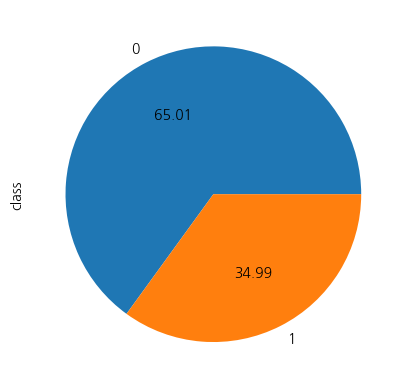

In [ ]:
# class (2 for benign, 4 for malignant) 비율 확인
df['class'].value_counts().plot.pie(autopct='%.2f');

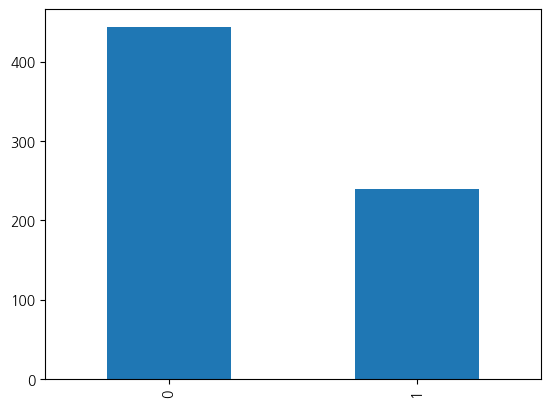

In [ ]:
df['class'].value_counts().plot.bar();

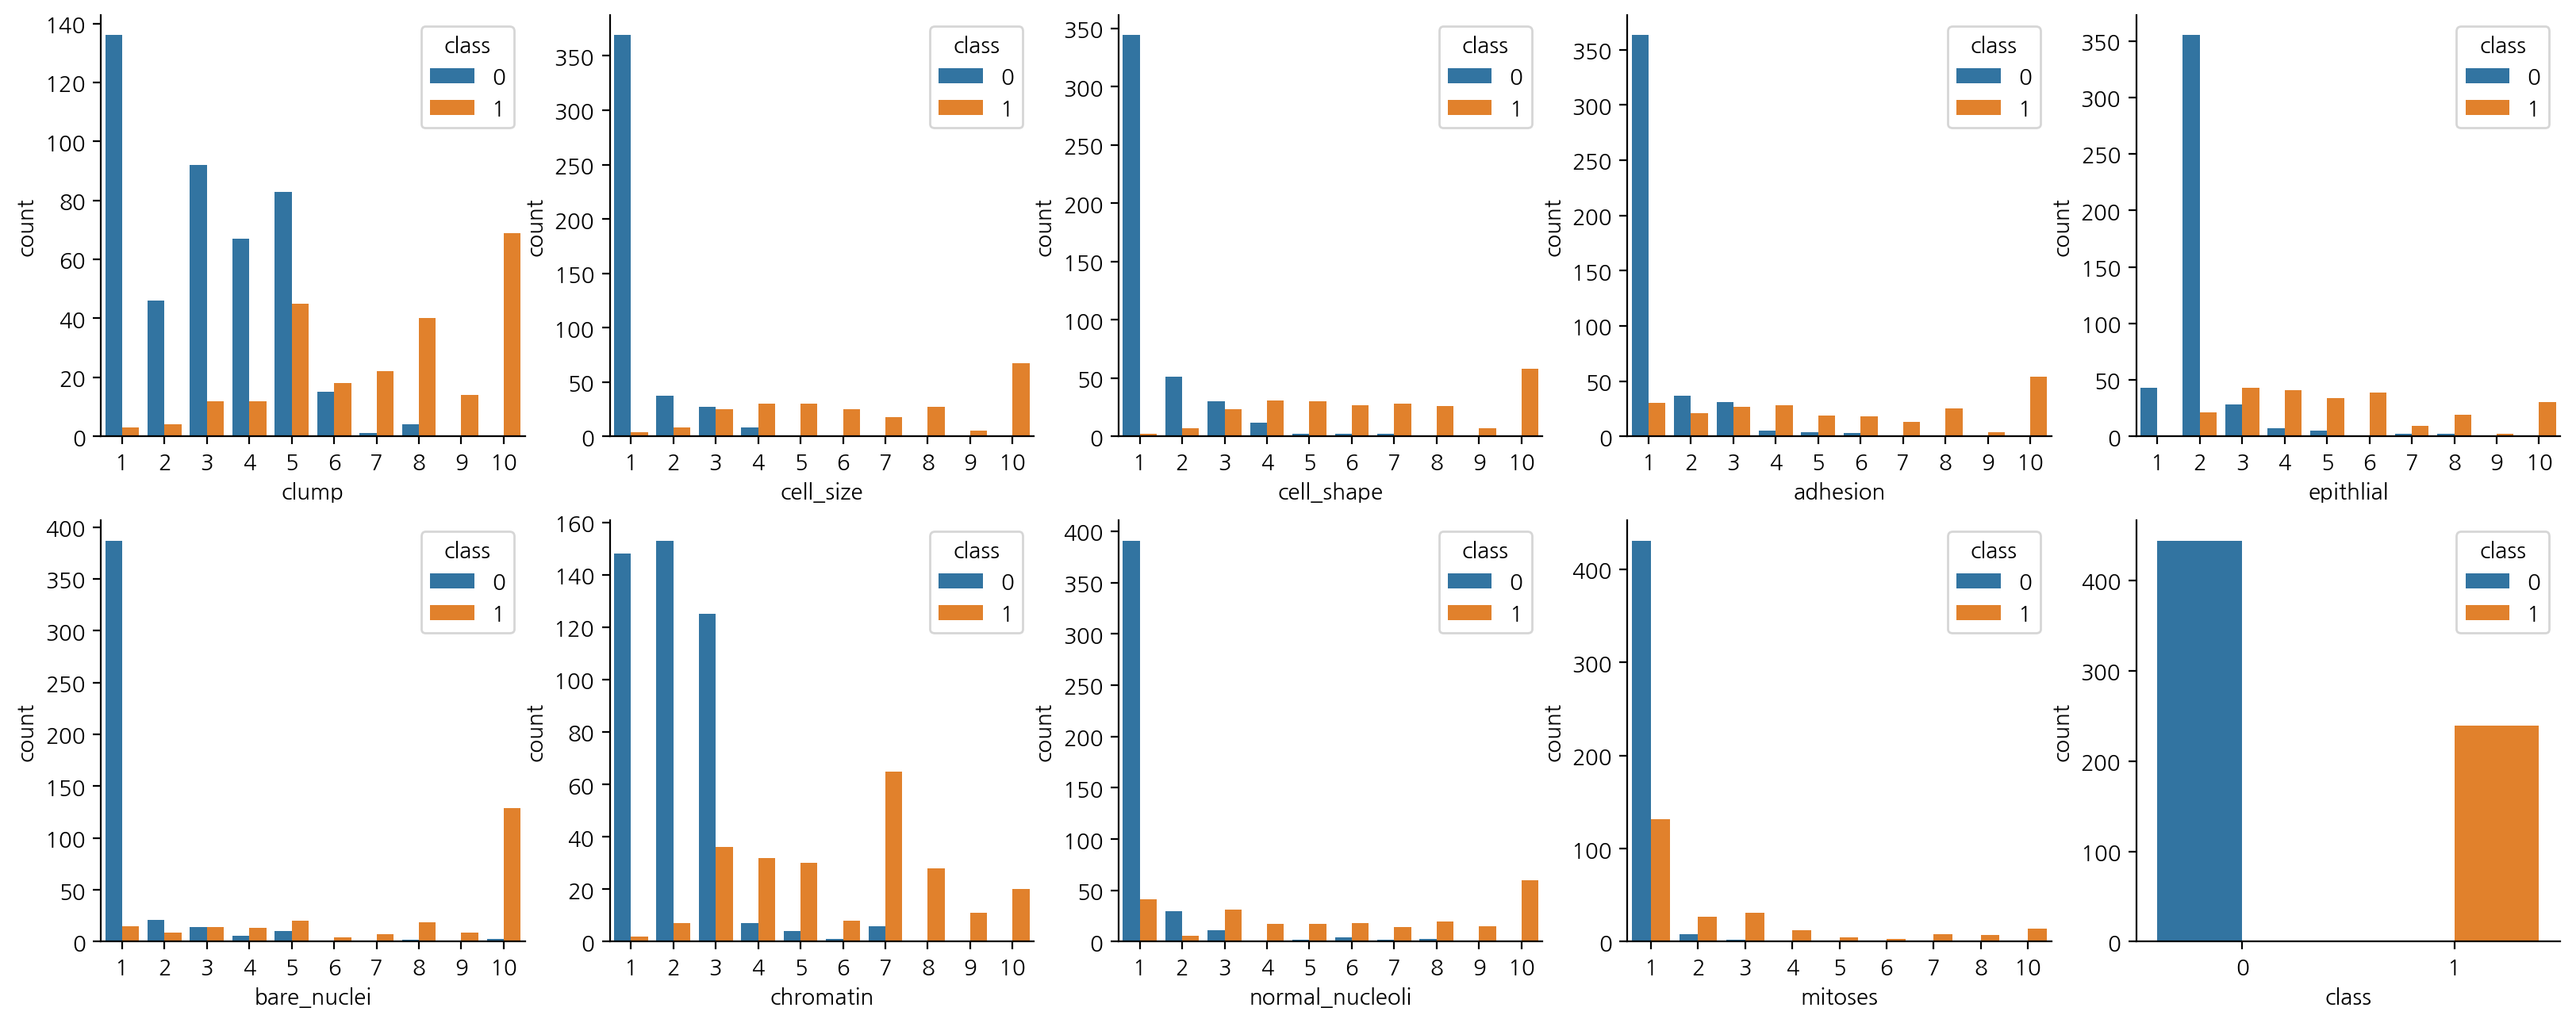

In [ ]:
# id 칼럼을 제외한 Target과 Feature의 연관성 확인
attrs = df.columns[1:]

plt.figure(figsize=(20, 20), dpi = 200)

for i, feature in enumerate(attrs) :
  plt.subplot(5, 5, i+1)
  sns.countplot(df, x = feature, hue = 'class')

sns.despine()

## 데이터 분리하기

In [ ]:
X = df[df.columns[1:-1]] # id, class 칼럼을 제외한 feature 데이터프레임
y = df[df.columns[-1]] # class 칼럼의 target 시리즈

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

print('X_train.shape : ', X_train.shape)
print('X_test.shape : ', X_test.shape)

X_train.shape :  (478, 9)
X_test.shape :  (205, 9)


## 데이터 정규화

In [ ]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[ 0.19790469, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299, ..., -0.18182716,
        -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       ...,
       [ 0.19790469,  2.23617957,  2.2718962 , ...,  1.86073779,
         2.33747554,  0.22916583],
       [-0.15686934,  1.58320366,  0.93248739, ...,  2.67776377,
         1.02618536, -0.34839971],
       [-0.15686934,  1.58320366,  1.6021918 , ...,  2.67776377,
         0.37054027, -0.34839971]])

## DesicionTree 분류 모델 설정

In [ ]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)


## 모델 학습하기

In [ ]:
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

## 모델 예측하기

In [ ]:
y_pred = tree_model.predict(X_test)

## 모델 성능 평가하기

In [ ]:
print('훈련 데이터셋 정확도 : ', tree_model.score(X_train, y_train))
print('테스트 데이터셋 정확도 : ', tree_model.score(X_test, y_test))

훈련 데이터셋 정확도 :  0.9769874476987448
테스트 데이터셋 정확도 :  0.9463414634146341


In [ ]:
tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       133
           1       0.90      0.96      0.93        72

    accuracy                           0.95       205
   macro avg       0.94      0.95      0.94       205
weighted avg       0.95      0.95      0.95       205



In [ ]:
print('accuracy : ', metrics.accuracy_score(y_test, y_pred))
print('precision : ', metrics.precision_score(y_test, y_pred))
print('recall : ', metrics.recall_score(y_test, y_pred))
print('f1 : ', metrics.f1_score(y_test, y_pred))

accuracy :  0.9463414634146341
precision :  0.8961038961038961
recall :  0.9583333333333334
f1 :  0.9261744966442952


## 결정트리 그래프 그리기

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(tree_model, out_file='tree.dot', class_names=['양성', '악성'],
                feature_names=df.columns[1:10], impurity=False, filled=True)

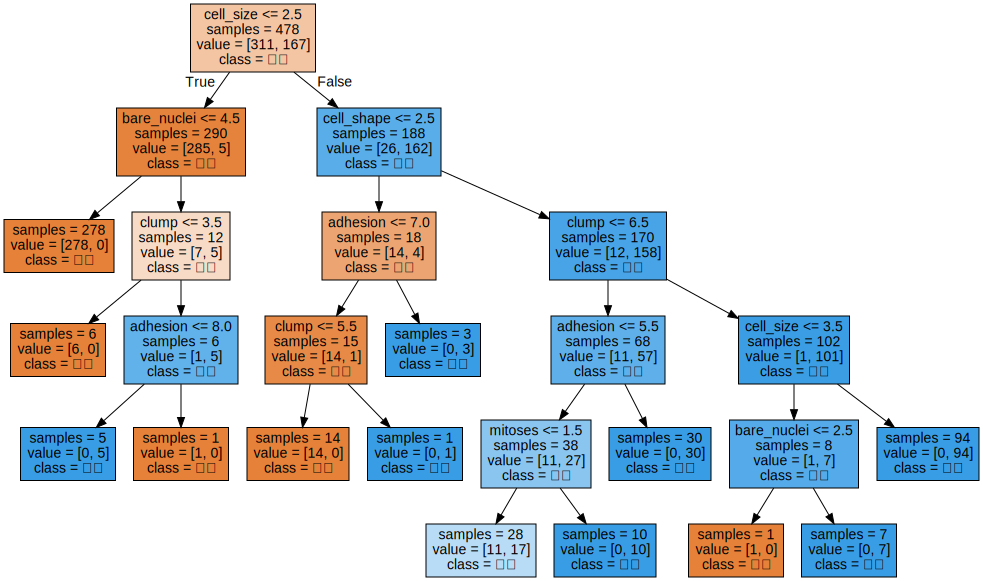

In [ ]:
import graphviz

with open('tree.dot') as f:
  dot_graph = f.read()

display(graphviz.Source(dot_graph))

## max_depth 변화에 따른 성능평가


*   성능평가 시각화



In [ ]:
# 1~20 까지 max_depth를 변화시켜 가장 최적의 max_depth 찾기

train_scores = {}
test_scores = {}

# tree max_depth 1 ~ 20까지 증가시켜 정확도 측정
for idx in np.arange(1,20) :
  tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=idx).fit(X_train, y_train)
  train_scores[idx] = tree_model.score(X_train, y_train)
  test_scores[idx] = tree_model.score(X_test, y_test)

# 훈련, 테스트셋의 가장 높은 정확도의 max_depth 확인
max_train_key = max(train_scores, key = train_scores.get)
max_test_key = max(test_scores, key = test_scores.get)

print('훈련 데이터셋 최적의 max_depth : ', max_train_key, '정확도 : ', train_scores[max_train_key])
print('테스트 데이터셋 최적의 max_depth : ', max_test_key, '정확도 : ', test_scores[max_test_key])

훈련 데이터셋 최적의 max_depth :  10 정확도 :  1.0
테스트 데이터셋 최적의 max_depth :  6 정확도 :  0.9512195121951219


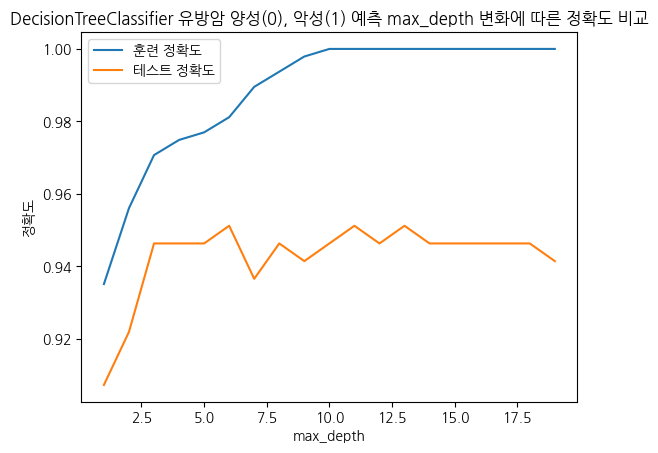

In [ ]:
plt.title('DecisionTreeClassifier 유방암 양성(0), 악성(1) 예측 max_depth 변화에 따른 정확도 비교')
plt.plot(train_scores.keys(), train_scores.values(), label = '훈련 정확도')
plt.plot(test_scores.keys(), test_scores.values(), label = '테스트 정확도')

plt.ylabel('정확도')
plt.xlabel('max_depth')
plt.legend()
plt.show()

In [ ]:
## 최적화 모델

tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)

tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

print('훈련 데이터셋 정확도 : ', tree_model.score(X_train, y_train))
print('테스트 데이터셋 정확도 : ', tree_model.score(X_test, y_test))

tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

print('accuracy : ', metrics.accuracy_score(y_test, y_pred))
print('precision : ', metrics.precision_score(y_test, y_pred))
print('recall : ', metrics.recall_score(y_test, y_pred))
print('f1 : ', metrics.f1_score(y_test, y_pred))

훈련 데이터셋 정확도 :  0.9811715481171548
테스트 데이터셋 정확도 :  0.9512195121951219
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       133
           1       0.96      0.90      0.93        72

    accuracy                           0.95       205
   macro avg       0.95      0.94      0.95       205
weighted avg       0.95      0.95      0.95       205

accuracy :  0.9512195121951219
precision :  0.9558823529411765
recall :  0.9027777777777778
f1 :  0.9285714285714286


In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(tree_model, out_file='tree.dot', class_names=['양성', '악성'],
                feature_names=df.columns[1:10], impurity=False, filled=True)

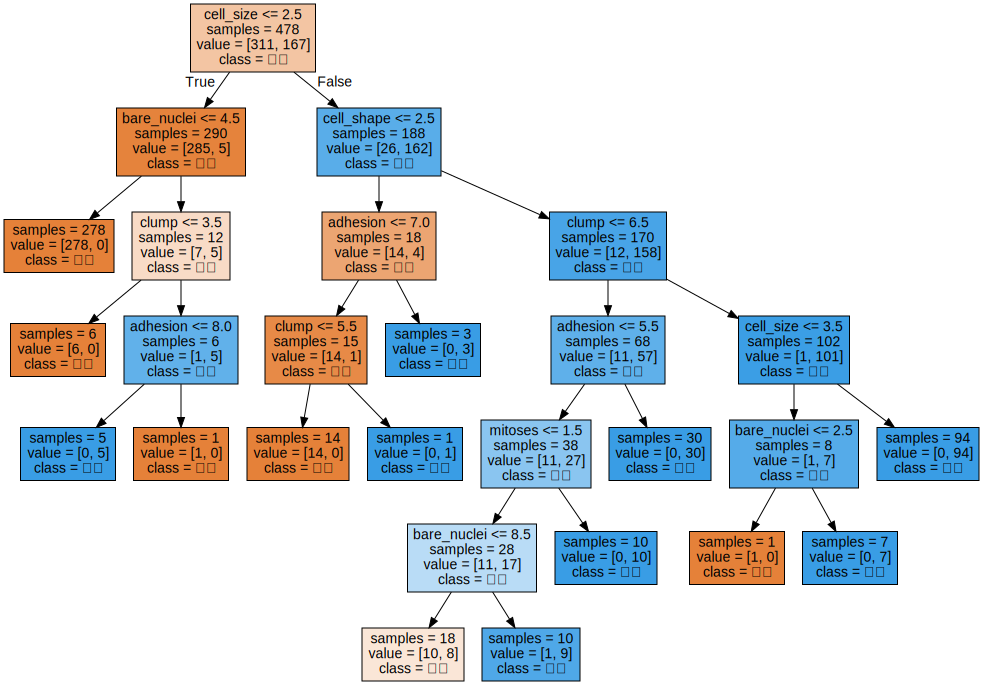

In [ ]:
import graphviz

with open('tree.dot') as f:
  dot_graph = f.read()

display(graphviz.Source(dot_graph))

In [ ]:
# class 칼럼의 값을 2 -> 0, 4 -> 1로 변경
df['target'] = np.where(df['class']== 2, 0, 1)
df.head()

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class,target
0,1000025,5,1,1,1,2,1,3,1,1,2,0
1,1002945,5,4,4,5,7,10,3,2,1,2,0
2,1015425,3,1,1,1,2,2,3,1,1,2,0
3,1016277,6,8,8,1,3,4,3,7,1,2,0
4,1017023,4,1,1,3,2,1,3,1,1,2,0


<Axes: ylabel='target'>

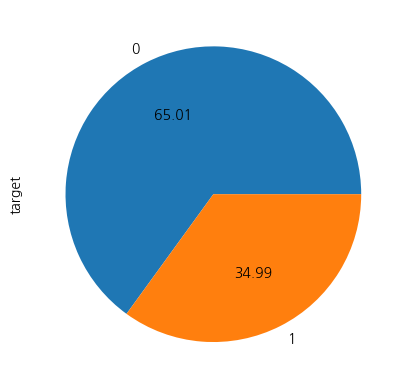

In [ ]:
df['target'].value_counts().plot.pie(autopct='%.2f')

In [ ]:
# X, y로 분리 후 X 값 정규화 (preprocessing.StandardScaler() 사용)
X = df[df.columns[1:-2]]
y = df[df.columns[-1]]

X

,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1
...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1
695,2,1,1,1,2,1,1,1,1
696,5,10,10,3,7,3,8,10,2
697,4,8,6,4,3,4,10,6,1


In [ ]:
# X 값 정규화 preprocessing.StandardScaler() 사용)
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[ 0.19790469, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299, ..., -0.18182716,
        -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       ...,
       [ 0.19790469,  2.23617957,  2.2718962 , ...,  1.86073779,
         2.33747554,  0.22916583],
       [-0.15686934,  1.58320366,  0.93248739, ...,  2.67776377,
         1.02618536, -0.34839971],
       [-0.15686934,  1.58320366,  1.6021918 , ...,  2.67776377,
         0.37054027, -0.34839971]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

In [ ]:
# 1~10 까지 max_depth를 변화시켜 가장 최적의 max_depth 찾기

train_scores = {}
test_scores = {}

# tree max_depth 1 ~ 10까지 증가시켜 정확도 측정
for idx in np.arange(1,11) :
  tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=idx).fit(X_train, y_train)
  train_scores[idx] = tree_model.score(X_train, y_train)
  test_scores[idx] = tree_model.score(X_test, y_test)

# 훈련, 테스트셋의 가장 높은 정확도의 max_depth 확인
max_train_key = max(train_scores, key = train_scores.get)
max_test_key = max(test_scores, key = test_scores.get)

print('훈련 데이터셋 최적의 max_depth : ', max_train_key, '정확도 : ', train_scores[max_train_key])
print('테스트 데이터셋 최적의 max_depth : ', max_test_key, '정확도 : ', test_scores[max_test_key])

훈련 데이터셋 최적의 max_depth :  10 정확도 :  1.0
테스트 데이터셋 최적의 max_depth :  6 정확도 :  0.9512195121951219


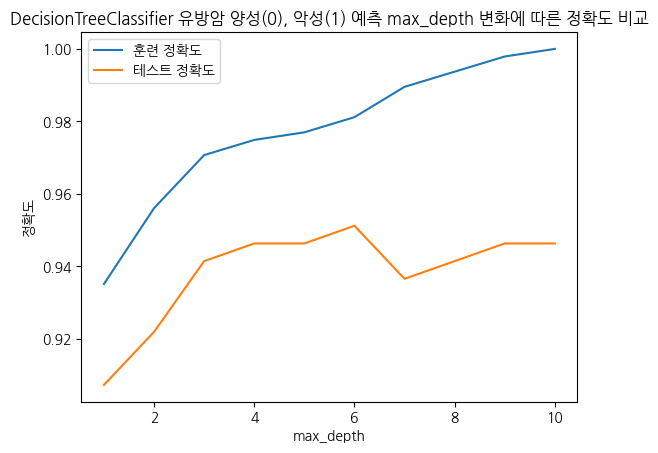

In [ ]:
plt.title('DecisionTreeClassifier 유방암 양성(0), 악성(1) 예측 max_depth 변화에 따른 정확도 비교')
plt.plot(train_scores.keys(), train_scores.values(), label = '훈련 정확도')
plt.plot(test_scores.keys(), test_scores.values(), label = '테스트 정확도')

plt.ylabel('정확도')
plt.xlabel('max_depth')
plt.legend()
plt.show()

In [ ]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6).fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

print('accuracy : ', metrics.accuracy_score(y_test, y_pred))
print('precision : ', metrics.precision_score(y_test, y_pred))
print('recall : ', metrics.recall_score(y_test, y_pred))
print('f1 : ', metrics.f1_score(y_test, y_pred))

accuracy :  0.9512195121951219
precision :  0.9558823529411765
recall :  0.9027777777777778
f1 :  0.9285714285714286


recall 이 높은 모델로 선택해야한다 !

## recall(재현율)이 가장 높은 모델 찾기

In [ ]:
# 1~10 까지 max_depth를 변화시켜 가장 최적의 max_depth 찾기

test_precision = {}
test_recall = {}

# tree max_depth 1 ~ 20까지 증가시켜 precision, recall 측정
for idx in np.arange(1,21) :
  tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=idx).fit(X_train, y_train)

  y_pred = tree_model.predict(X_test)

  test_precision[idx] = metrics.precision_score(y_test, y_pred)
  test_recall[idx] = metrics.recall_score(y_test, y_pred)

# 가장 높은 precision, recall의 max_depth 확인
max_precision_key = max(test_precision, key = test_precision.get)
max_recall_key = max(test_recall, key = test_recall.get)

print('최적의 precision_max_depth : ', max_precision_key, 'precision : ', test_precision[max_precision_key])
print('최적의 recall max_depth : ', max_recall_key, 'recall : ', test_recall[max_recall_key])

최적의 precision_max_depth :  6 precision :  0.9558823529411765
최적의 recall max_depth :  4 recall :  0.9583333333333334


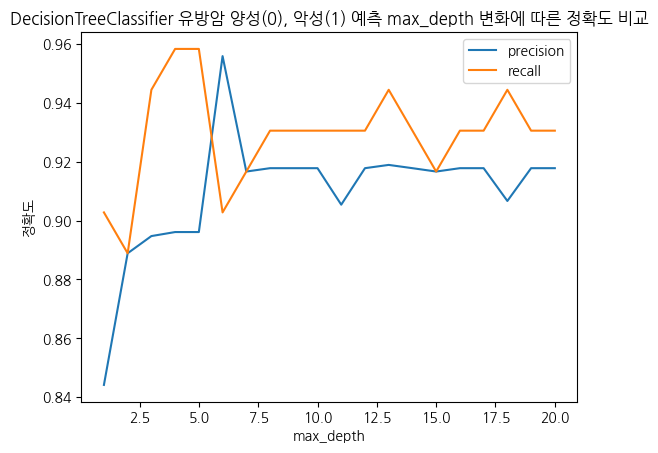

In [ ]:
plt.title('DecisionTreeClassifier 유방암 양성(0), 악성(1) 예측 max_depth 변화에 따른 정확도 비교')
plt.plot(test_precision.keys(), test_precision.values(), label = 'precision')
plt.plot(test_recall.keys(), test_recall.values(), label = 'recall')

plt.ylabel('정확도')
plt.xlabel('max_depth')
plt.legend()
plt.show()

In [ ]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4).fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

print('accuracy : ', metrics.accuracy_score(y_test, y_pred))
print('precision : ', metrics.precision_score(y_test, y_pred))
print('recall : ', metrics.recall_score(y_test, y_pred))
print('f1 : ', metrics.f1_score(y_test, y_pred))

accuracy :  0.9463414634146341
precision :  0.8961038961038961
recall :  0.9583333333333334
f1 :  0.9261744966442952


In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(tree_model, out_file='tree.dot', class_names=['양성', '악성'],
                feature_names=df.columns[1:10], impurity=False, filled=True)

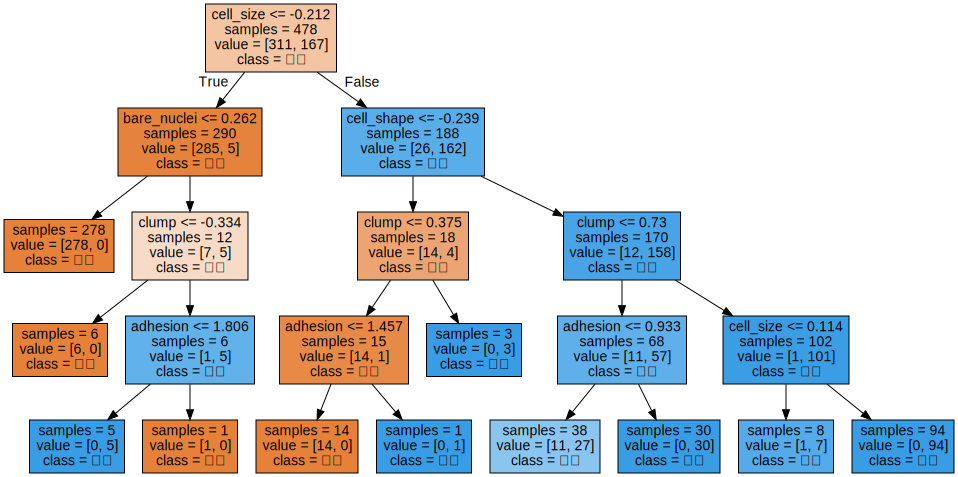

In [ ]:
import graphviz

with open('tree.dot') as f:
  dot_graph = f.read()

display(graphviz.Source(dot_graph))